In [1]:
try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/feature-circuits
    %pip install -r requirements.txt
    !git submodule update --init
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os

import torch
from nnsight import LanguageModel

from circuit import get_circuit
from utils import save_circuit
from utils import plot_circuit
from dictionary_learning import AutoEncoder

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE :", DEVICE)

print("IN_COLAB :", IN_COLAB)

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE : cuda
IN_COLAB : False


In [2]:
pythia70m = LanguageModel("EleutherAI/pythia-70m-deduped", device_map=DEVICE, dispatch=True)

pythia70m_embed = pythia70m.gpt_neox.embed_in

pythia70m_resids= []
pythia70m_attns = []
pythia70m_mlps = []
for layer in range(len(pythia70m.gpt_neox.layers)):
    pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
    pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
    pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
if IN_COLAB:
    base = "/content/gdrive/MyDrive/feature-circuits/"
else:
    #base = "C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits/"
    base = 'C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/'
path = base + "dictionary_learning/dictionaires/pythia-70m-deduped/"

if not os.path.exists(path):
    if IN_COLAB:
        # go to base / dictionary_learning :
        %cd /content/gdrive/MyDrive/feature-circuits/dictionary_learning
        !apt-get update
        !apt-get install dos2unix
        !dos2unix pretrained_dictionary_downloader.sh
        !chmod +x pretrained_dictionary_downloader.sh
        !./pretrained_dictionary_downloader.sh
        %cd /content/gdrive/MyDrive/feature-circuits
    else:
        %cd C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits/dictionary_learning
        %run ./pretrained_dictionary_downloader.sh
        %cd C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits

dictionaries = {}

d_model = 512
dict_size = 32768

ae = AutoEncoder(d_model, dict_size).to(DEVICE)
ae.load_state_dict(torch.load(path + f"embed/ae.pt", map_location=DEVICE))
dictionaries[pythia70m_embed] = ae


for layer in range(len(pythia70m.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_resids[layer]] = ae

    # ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    # ae.load_state_dict(torch.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
    # dictionaries[pythia70m_attns[layer]] = ae

    # ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    # ae.load_state_dict(torch.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
    # dictionaries[pythia70m_mlps[layer]] = ae

In [4]:
def metric_fn_v1(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return logits[torch.arange(trg.numel()), trg]
    
def metric_fn_v2(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,trg[0],:]
    return logits[0, 0, trg[1]]

def metric_fn_v3(model, trg=None):
    """
    Return -log probability for the expected target.

    trg : torch.Tensor, contains idxs of the target tokens (between 0 and d_vocab_out)

    /!\ here we assume that all last tokens are indeed in the last position (if padding, it must happen in front of the sequence, not after)
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return (
         -1 * torch.gather(
             torch.nn.functional.log_softmax(model.embed_out.output[:,-1,:], dim=-1),
             dim=-1, index=trg.view(-1, 1)
         ).squeeze(-1)
    )

In [5]:
batch_size = 1

clean = [
    "When Mary and John went to the store, John gave a drink to"
    for _ in range(batch_size)
]
patch = None

trg = " Mary"
trg_idx = torch.tensor([pythia70m.tokenizer.encode(trg)[0]] * batch_size, device=DEVICE)
print(trg_idx)

tensor([6393], device='cuda:0')


In [6]:
circuit = get_circuit(
    clean, patch,
    pythia70m,
    dictionaries,
    metric_fn_v1,
    pythia70m_embed, pythia70m_resids,
    metric_kwargs={"trg": trg_idx},
    original_marks=False,
    normalise_edges=True,
    edge_threshold=0.8
)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Computing effects for layer 5 with 23 features
Computing effects for layer 4 with 175 features
Computing effects for layer 3 with 622 features
Computing effects for layer 2 with 1022 features
Computing effects for layer 1 with 764 features
Computing effects for layer 0 with 901 features


In [7]:
import evaluation

digraph = evaluation.to_Digraph(circuit)

In [8]:
pruned = evaluation.prune(digraph)

In [9]:
sparsity = evaluation.sparsity(digraph)
sparsity_pruned = evaluation.sparsity(pruned)

print('Stats of the original graph :')
print(sparsity)
print('\n\nStats of the pruned graph :')
print(sparsity_pruned)

Stats of the original graph :
{'nedges': 124719, 'nnodes': 1919, 'avgdegree': 129.9833246482543, 'connected_components': 1, 'density': 0.0338851211283249, 'degree_distribution': [0, 0, 4, 10, 11, 5, 3, 10, 7, 8, 6, 5, 7, 9, 6, 8, 3, 7, 10, 9, 6, 6, 4, 8, 6, 8, 7, 3, 9, 10, 17, 6, 8, 7, 13, 12, 10, 11, 11, 17, 14, 5, 9, 13, 11, 7, 9, 12, 17, 6, 10, 13, 9, 9, 8, 12, 10, 13, 8, 8, 15, 14, 9, 15, 7, 12, 7, 8, 11, 13, 9, 8, 6, 17, 8, 9, 11, 16, 11, 9, 9, 9, 11, 12, 13, 4, 9, 17, 8, 10, 9, 8, 11, 6, 7, 9, 4, 9, 6, 5, 12, 11, 6, 3, 13, 8, 7, 10, 10, 5, 6, 6, 6, 6, 14, 10, 10, 15, 7, 9, 9, 9, 9, 7, 10, 4, 9, 12, 3, 9, 10, 4, 6, 7, 13, 6, 7, 5, 10, 7, 2, 3, 2, 5, 5, 7, 7, 6, 9, 9, 12, 4, 4, 7, 6, 9, 7, 7, 7, 5, 7, 5, 8, 3, 7, 6, 3, 9, 7, 5, 6, 4, 5, 5, 7, 5, 3, 5, 2, 5, 4, 3, 6, 4, 4, 5, 9, 3, 4, 7, 3, 4, 3, 1, 5, 2, 1, 4, 6, 6, 2, 4, 6, 1, 3, 3, 5, 8, 5, 5, 0, 1, 3, 2, 3, 5, 3, 3, 4, 1, 2, 5, 5, 1, 3, 5, 2, 2, 3, 3, 1, 5, 0, 5, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, 1, 3, 5, 4, 1, 2, 1, 2, 3, 2, 2, 

[0, 0, 0, 0, 0, 0, 0]
[16, 78, 60, 40, 29, 27, 36, 29, 23, 23]
[1, 143, 57, 46, 27, 24, 17, 24, 21, 16]


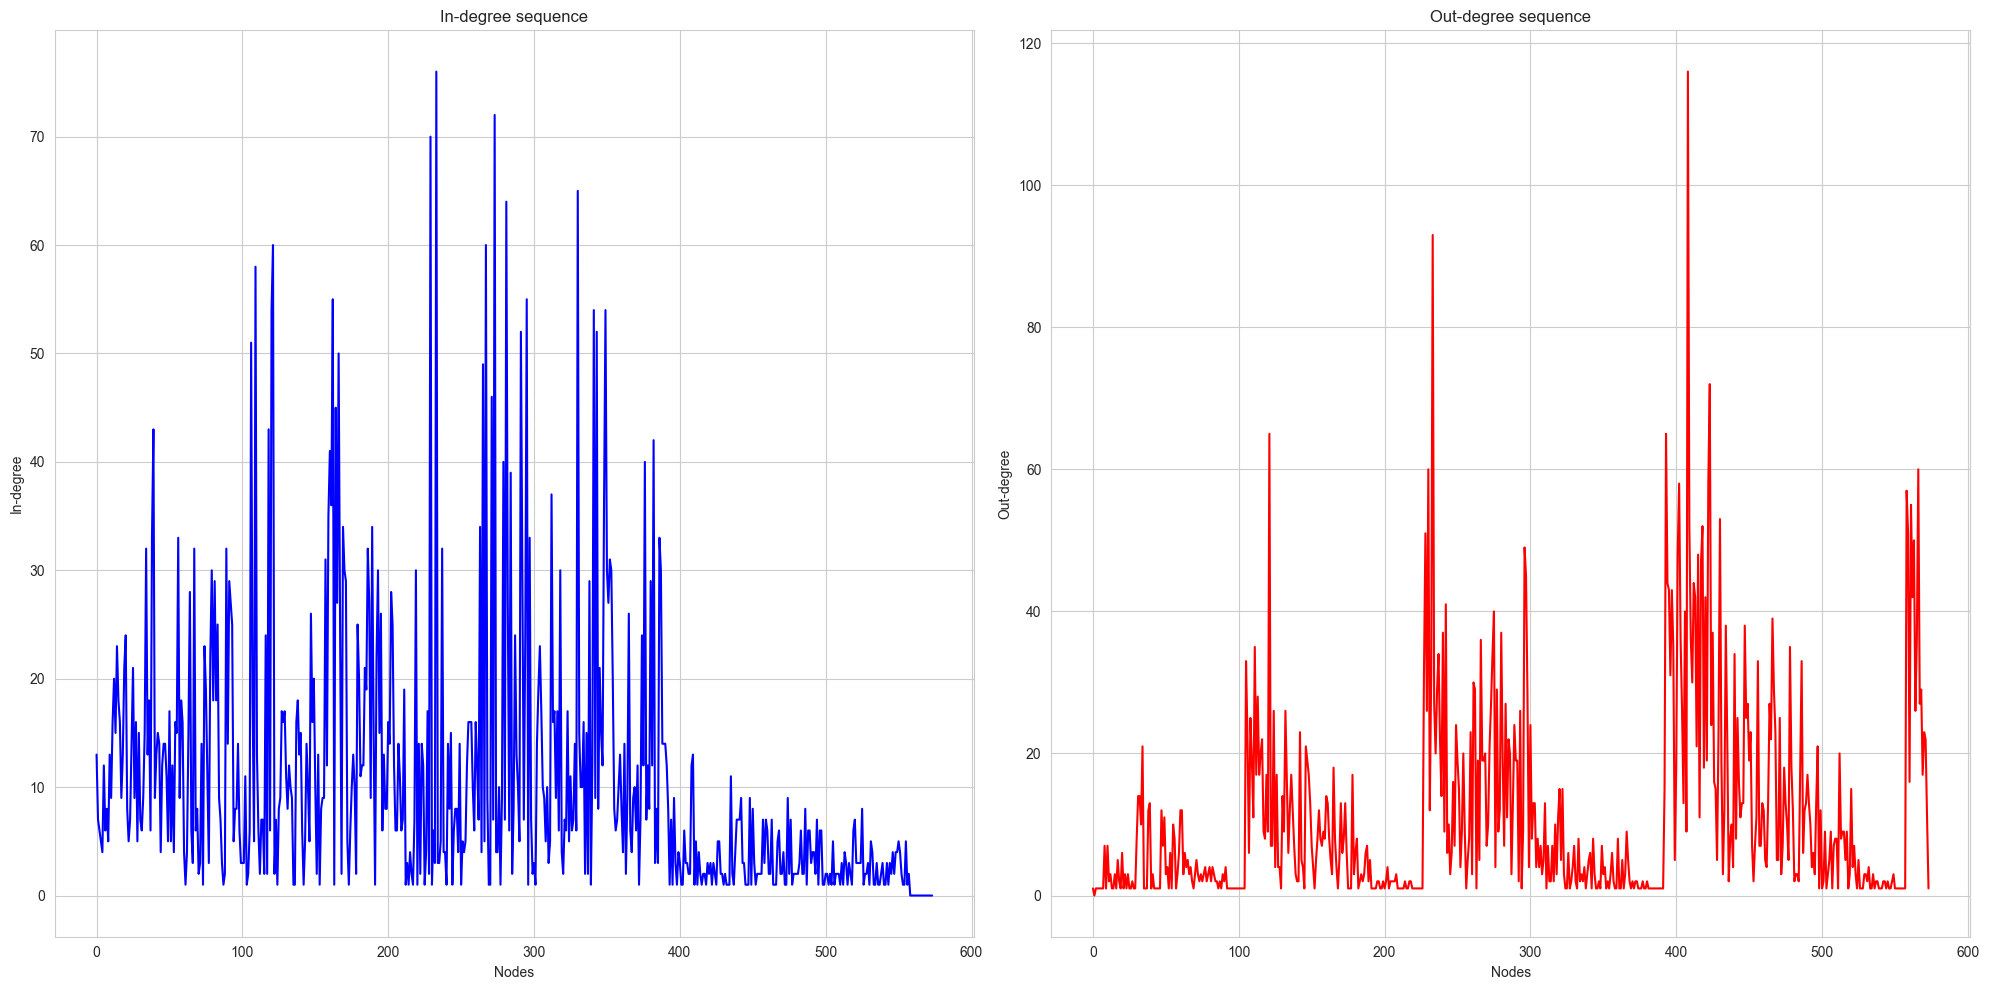

In [11]:
layer_count = [0] * (len(pythia70m_resids) + 1)
print(layer_count)

# Get in-degree and out-degree sequences
in_degrees = [d for n, d in digraph.in_degree()]
out_degrees = [d for n, d in digraph.out_degree()]

# Compute in-degree and out-degree histograms
in_degree_histogram = [in_degrees.count(i) for i in range(max(in_degrees)+1)]
out_degree_histogram = [out_degrees.count(i) for i in range(max(out_degrees)+1)]

print(in_degree_histogram[:10])
print(out_degree_histogram[:10])

import matplotlib.pyplot as plt

# Plot in-degree and out-degree sequences
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(in_degrees, color='blue')
plt.xlabel('Nodes')
plt.ylabel('In-degree')
plt.title('In-degree sequence')
plt.subplot(122)
plt.plot(out_degrees, color='red')
plt.xlabel('Nodes')
plt.ylabel('Out-degree')
plt.title('Out-degree sequence')
plt.tight_layout()
plt.show()

In [10]:
# Get in-degree and out-degree sequences
in_degrees_per_layer = [[] for _ in range(len(pythia70m_resids) + 1)]
out_degrees_per_layer = [[] for _ in range(len(pythia70m_resids) + 1)]
nodes_per_layer = [0 for _ in range(len(pythia70m_resids) + 1)]

for n in digraph.nodes():
    if n == 'y':
        continue
    layer = 0 if n.startswith('embed') else int(n.split('_')[1]) + 1
    in_degrees_per_layer[layer].append(digraph.in_degree(n))
    out_degrees_per_layer[layer].append(digraph.out_degree(n))
    nodes_per_layer[layer] += 1

# Compute in-degree and out-degree histograms
for layer in range(len(pythia70m_resids) + 1):
    in_degree_histogram = [in_degrees_per_layer[layer].count(i) for i in range(max(in_degrees_per_layer[layer])+1)]
    out_degree_histogram = [out_degrees_per_layer[layer].count(i) for i in range(max(out_degrees_per_layer[layer])+1)]

    print(f"Layer {layer}")
    print(nodes_per_layer[layer])
    print(in_degree_histogram[:10])
    print(out_degree_histogram[:10])

    # # Plot in-degree and out-degree sequences
    # plt.figure(figsize=(20, 10))
    # plt.subplot(121)
    # plt.plot(in_degrees_per_layer[layer], color='blue')
    # plt.xlabel('Nodes')
    # plt.ylabel('In-degree')
    # plt.title('In-degree sequence')
    # plt.subplot(122)
    # plt.plot(out_degrees_per_layer[layer], color='red')
    # plt.xlabel('Nodes')
    # plt.ylabel('Out-degree')
    # plt.title('Out-degree sequence')
    # plt.tight_layout()
    # plt.show()

Layer 0
17
[17]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Layer 1
425
[0, 43, 38, 41, 28, 29, 21, 24, 36, 22]
[0, 6, 3, 6, 3, 0, 2, 2, 2, 3]
Layer 2
475
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 7, 3, 1, 3, 4, 3, 3, 3, 0]
Layer 3
736
[0, 0, 0, 0, 1, 3, 9, 11, 8, 2]
[0, 25, 6, 13, 14, 9, 4, 5, 7, 6]
Layer 4
462
[0, 0, 0, 0, 0, 0, 3, 2, 0, 0]
[0, 14, 10, 8, 12, 13, 7, 7, 9, 4]
Layer 5
209
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[0, 23, 15, 7, 2, 7, 3, 4, 6, 7]
Layer 6
37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 37]


Computing effects for layer 5 with 16 features
Computing effects for layer 4 with 26 features
Computing effects for layer 3 with 67 features
Computing effects for layer 2 with 533 features
Computing effects for layer 1 with 129 features
Computing effects for layer 0 with 101 features

In [ ]:
import evaluation
import importlib
importlib.reload(evaluation)

mask = evaluation.get_mask(circuit, 0.5)
pruned = evaluation.prune(mask)

Now looking at edges from upstream embed
arriving at downstream resid_0
Now looking at edges from upstream resid_0
arriving at downstream resid_1
Now looking at edges from upstream resid_1
arriving at downstream resid_2
Now looking at edges from upstream resid_2
arriving at downstream resid_3
Now looking at edges from upstream resid_3
arriving at downstream resid_4
Now looking at edges from upstream resid_4
arriving at downstream resid_5
Now looking at edges from upstream resid_5
arriving at downstream y


- cpu :
    - 1 : 2m47
    - 2 : /
    - 10: Stop at 68m+

- gpu :
    - 1 : 42s
    - 2 : 1m32

In [ ]:
submod_1 = "resid_0"
submod_2 = "resid_1"

weights = circuit[1][submod_1][submod_2]
weights = weights.values()

from matplotlib import pyplot as plt

alive_downstream = circuit[1][submod_1][submod_2].indices()[0]
set_downstream = list(set([alive_downstream_.item() for alive_downstream_ in alive_downstream]))

ss = []
abss = []
nb_k = []

from tqdm import tqdm

for k in tqdm(set_downstream):
    weights = []
    for i, idx in enumerate(alive_downstream):
        if idx == k:
            weights.append(circuit[1][submod_1][submod_2].values()[i])
    weights = torch.stack(weights)

    perm = torch.argsort(weights.abs(), descending=True)
    weights = weights[perm]
    tot = sum(weights)
    s = 0
    for i in range(len(weights)):
        s += weights[i]
        if i < len(ss):
            ss[i] += (s / tot).item()
        else:
            ss.append((s / tot).item())
        if i < len(abss):
            abss[i] += weights[i].abs().item()
        else:
            abss.append(weights[i].abs().item())
        if i < len(nb_k):
            nb_k[i] += 1
        else:
            nb_k.append(1)
        # print("i :", i)
        # print("weight :", embed_weights[i].item())
        # print("% of total :", s.item() / tot.item() * 100)

ss = [ss[i] / nb_k[i] for i in range(len(ss))]
abss = [abss[i] / nb_k[i] for i in range(len(abss))]

"""
plot ss and abss on two different axis with the same x-axis on the same plot
"""
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('weight index')
ax1.set_ylabel('cumulative % of total', color=color)
ax1.plot(ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('weight', color=color)
ax2.plot(abss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [ ]:
max_weights = 100

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('weight index')
ax1.set_ylabel('cumulative % of total', color=color)
ax1.plot(ss[:max_weights], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('weight', color=color)
ax2.plot(abss[:max_weights], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [ ]:
import importlib
import circuit_plotting
importlib.reload(circuit_plotting)
circuit_plotting.plot_circuit(circuit[0], circuit[1], save_dir='./circuit/cpu_2_')

In [ ]:
all_weights = []
for key, value in circuit[1].items():
    for k, v in value.items():
        all_weights.append(v.values())
        
all_weights = torch.cat(all_weights, dim=0)
print(all_weights.shape)
print(all_weights.abs().mean())

plt.hist(all_weights[all_weights.abs() > 0.01].detach().cpu().numpy(), bins=100)
plt.show()

In [ ]:
A = torch.randn(1, 10, 50)
B = torch.randn(1, 10, 50)

print((A * B).shape)
print(A @ B)

In [ ]:
import torch

dummy_2d_sparse_idx = torch.tensor([[0, 99, 27], [1, 2, 199]])
dummy_2d_sparse_values = torch.randn(2, 3)

dummy_2d_sparse = torch.sparse_coo_tensor(
    dummy_2d_sparse_idx,
    dummy_2d_sparse_values,
    size=(100, 200)
)

print(dummy_2d_sparse.to_dense())

In [ ]:
print("hehehe_hahaha")
print("hehehe_hahaha".split("_"))
print("hehehehahaha".split("_"))

hehehe_hahaha
['hehehe', 'hahaha']
['hehehehahaha']
